# SARIMAX(x-denotes exogeneous model)


#-label-you want to predict
x-which is not related to label which is str coverted to numerical
can be converted by onehot encoding,creating dummy variable,
easily done by pd.get_dummies() command

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('tser_lec/Data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

# SARIMA(P,D,Q) MODEL¶

In [2]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [3]:
df1=df.dropna()

In [4]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


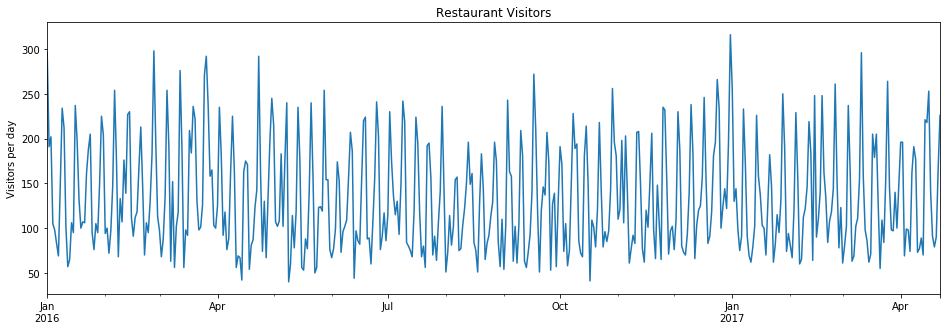

In [5]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [6]:
#df1.query('holiday==1').index
df1[df1['holiday']==1].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

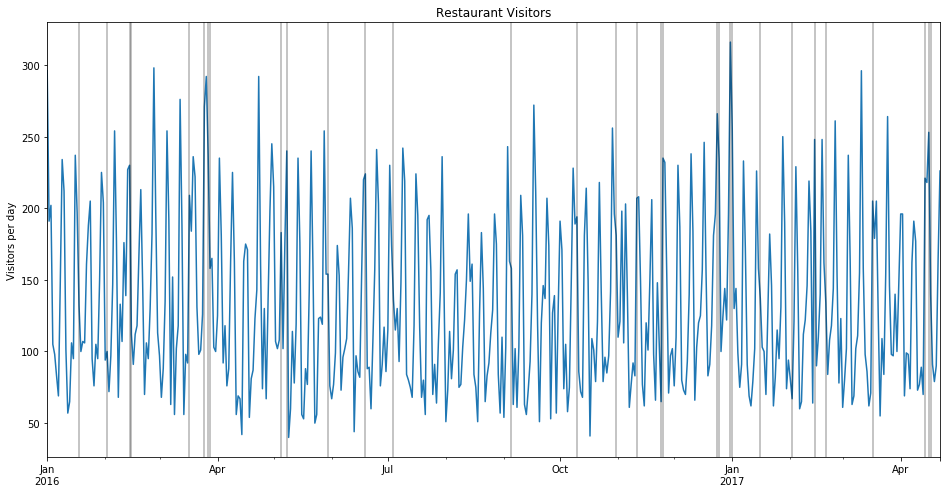

In [7]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for day in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=day, color='k', alpha = 0.3);  # add a semi-transparent grey line

# Run an ETS Decomposition

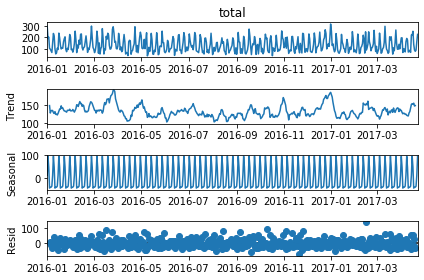

In [8]:
result = seasonal_decompose(df1['total'])
result.plot();

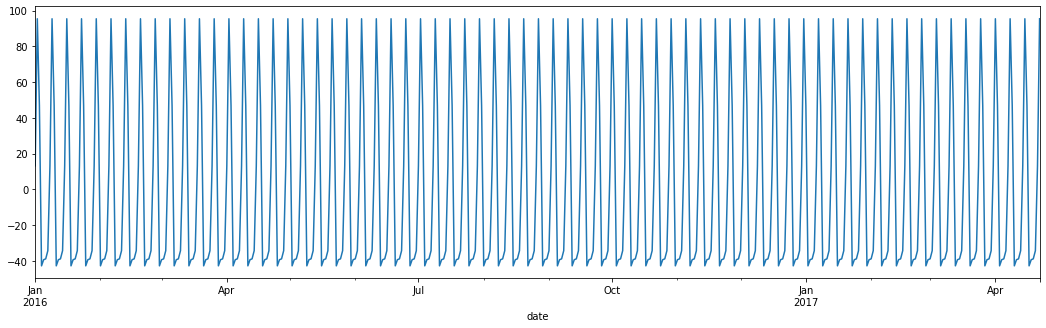

In [9]:
result.seasonal.plot(figsize=(18,5))

# Test for stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [11]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [12]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2384.908
Date:                   Wed, 13 May 2020   AIC                           4777.816
Time:                           11:19:53   BIC                           4794.495
Sample:                                0   HQIC                          4784.373
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.9779      1.671      2.979      0.003       1.702       8.253
ar.S.L7        0.9602      0.013     74.406      0.000       0.935       0.985
ma.S.L7       -0.7410      0.049    -15.252      0.000      -0.836      -0.646
sigma2      1193.9784     69.427     17.198      0.000    1057.904    1330.053
===================================================================================
Ljung-Box (Q):                       68.47   Jarque-Bera (JB):                62.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
len(df1)

478

In [14]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

# Fit a SARIMA(1,0,0)(2,0,0,7) Mode

In [37]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Wed, 13 May 2020   AIC                           4457.403
Time:                                   11:42:46   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fit a SARIMA(1,0,0)(2,0,0,7) Model
NOTE: To avoid a <tt>ValueError: non-invertible starting MA parameters found</tt> we're going to set <tt>enforce_invertibility</tt> to False.

In [38]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

In [39]:
predictions

2017-03-12    165.545789
2017-03-13     70.347485
2017-03-14     91.812941
2017-03-15     79.685118
2017-03-16     92.827732
2017-03-17    125.146755
2017-03-18    258.287857
2017-03-19    158.840400
2017-03-20     64.437579
2017-03-21     78.050927
2017-03-22     87.005009
2017-03-23     97.776468
2017-03-24    134.267530
2017-03-25    266.179030
2017-03-26    156.151930
2017-03-27     64.805972
2017-03-28     81.517760
2017-03-29     80.504059
2017-03-30     91.969827
2017-03-31    125.230235
2017-04-01    252.924302
2017-04-02    151.723451
2017-04-03     62.289183
2017-04-04     76.978117
2017-04-05     80.560631
2017-04-06     91.293339
2017-04-07    124.826312
2017-04-08    249.822466
2017-04-09    148.251359
2017-04-10     61.183338
2017-04-11     76.265309
2017-04-12     77.615599
2017-04-13     88.294719
2017-04-14    120.487931
2017-04-15    242.188871
2017-04-16    144.467607
2017-04-17     59.472167
2017-04-18     73.827851
2017-04-19     76.150281
2017-04-20     86.466950


In [40]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['total'][i]}")

predicted=165.5457894, expected=158
predicted=70.34748496, expected=98
predicted=91.81294084, expected=86
predicted=79.68511812, expected=62
predicted=92.82773172, expected=71
predicted=125.1467555, expected=205
predicted=258.2878574, expected=179
predicted=158.8403999, expected=205
predicted=64.43757863, expected=125
predicted=78.05092727, expected=55
predicted=87.00500894, expected=109
predicted=97.77646795, expected=84
predicted=134.2675304, expected=154
predicted=266.1790299, expected=264
predicted=156.1519303, expected=146
predicted=64.80597153, expected=98
predicted=81.51776019, expected=97
predicted=80.5040593 , expected=140
predicted=91.96982731, expected=100
predicted=125.2302354, expected=149
predicted=252.9243021, expected=196
predicted=151.7234512, expected=196
predicted=62.28918333, expected=69
predicted=76.97811724, expected=99
predicted=80.56063135, expected=98
predicted=91.29333924, expected=74
predicted=124.826312 , expected=162
predicted=249.822466 , expected=191
pred

In [41]:
test['total'].mean()

134.26190476190476

In [42]:
predictions.mean()

120.7259870797514

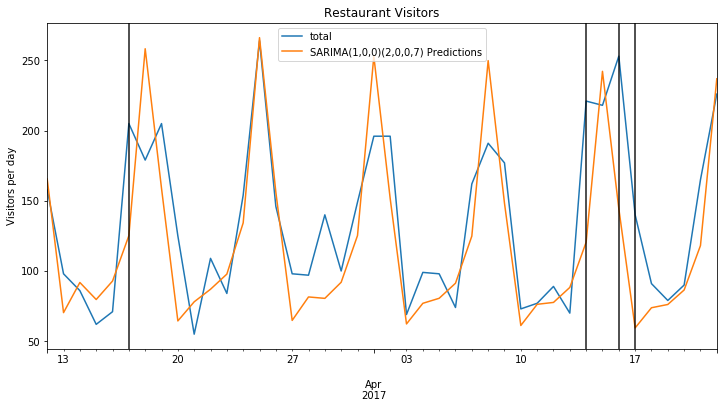

In [45]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.9);

# Evaluate the Model¶

In [44]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647956
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315495


# Now add the exog variable

In [46]:
auto_arima(df1['total'],exogeneous=df1[['holiday']],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2384.908
Date:                   Wed, 13 May 2020   AIC                           4777.816
Time:                           12:07:59   BIC                           4794.495
Sample:                                0   HQIC                          4784.373
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.9779      1.671      2.979      0.003       1.702       8.253
ar.S.L7        0.9602      0.013     74.406      0.000       0.935       0.985
ma.S.L7       -0.7410      0.049    -15.252      0.000      -0.836      -0.646
sigma2      1193.9784     69.427     17.198      0.000    1057.904    1330.053
===================================================================================
Ljung-Box (Q):                       68.47   Jarque-Bera (JB):                62.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# fit the new model by adding exo variable

In [47]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2223.861
Date:                           Wed, 13 May 2020   AIC                           4459.722
Time:                                   12:10:38   BIC                           4484.188
Sample:                               01-01-2016   HQIC                          4469.378
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday      173.0826      5.812     29.781      0.000     161.692     184.474
ar.L1          0.9983      0.006    176.496      0.000       0.987       1.009
ma.L1         -1.0073      0.022    -46.292      0.000      -1.050      -0.965
ar.S.L7        0.9985      0.002    595.228      0.000       0.995       1.002
ma.S.L7       -1.0849      0.045    -24.213      0.000      -1.173      -0.997
sigma2      1295.1992    136.440      9.493      0.000    1027.781    1562.617
===================================================================================
Ljung-Box (Q):                       55.54   Jarque-Bera (JB):               455.81
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -1.26
Prob(H) (two-sided):                  0.61   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,1)(1,0,1,7) Predictions')

In [49]:
predictions

2017-03-12    155.893005
2017-03-13     59.524394
2017-03-14     90.886125
2017-03-15     96.947374
2017-03-16     85.377637
2017-03-17    304.334467
2017-03-18    224.200808
2017-03-19    155.764836
2017-03-20     59.544674
2017-03-21     90.857837
2017-03-22     96.909544
2017-03-23     85.357459
2017-03-24    131.160717
2017-03-25    223.966121
2017-03-26    155.635515
2017-03-27     59.563574
2017-03-28     90.828248
2017-03-29     96.870430
2017-03-30     85.335973
2017-03-31    131.068392
2017-04-01    223.730460
2017-04-02    155.505060
2017-04-03     59.581115
2017-04-04     90.797376
2017-04-05     96.830049
2017-04-06     85.313196
2017-04-07    130.974888
2017-04-08    223.493842
2017-04-09    155.373488
2017-04-10     59.597313
2017-04-11     90.765239
2017-04-12     96.788421
2017-04-13     85.289145
2017-04-14    303.962844
2017-04-15    223.256286
2017-04-16    328.323441
2017-04-17    232.694809
2017-04-18     90.731854
2017-04-19     96.745562
2017-04-20     85.263839


In [50]:
predictions.mean()

136.87732320574534

In [53]:
test['total'].mean()

134.26190476190476

In [55]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647956
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315495

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 1372.764006
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 37.05083003


# Retrain the model on the full data, and forecast the future

In [59]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,1),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,1)(1,0,1,7) Forecast')

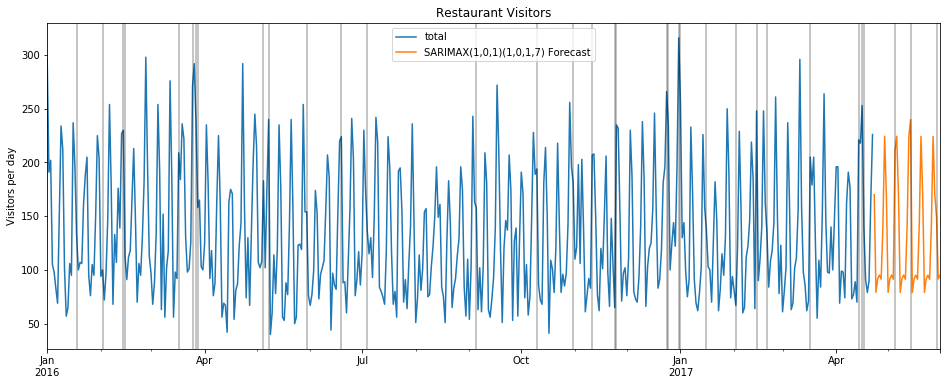

In [63]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

In [67]:
df.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [68]:
fcast.tail()

2017-05-27    224.183428
2017-05-28    169.791711
2017-05-29    149.032990
2017-05-30     91.535649
2017-05-31     95.080023
Freq: D, Name: SARIMAX(1,0,1)(1,0,1,7) Forecast, dtype: float64

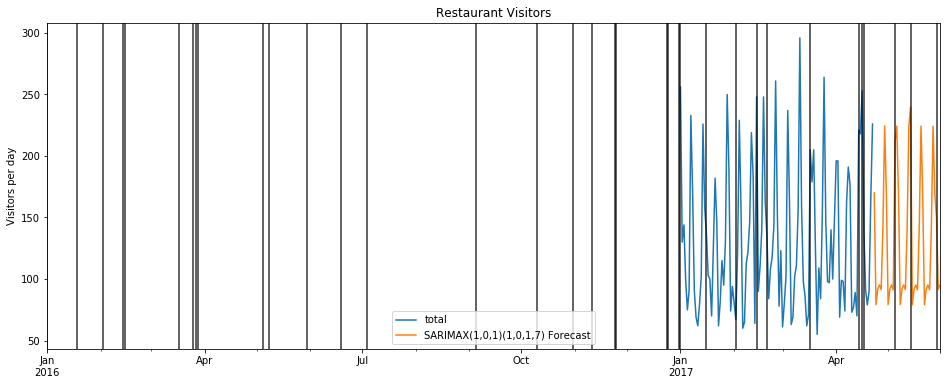

In [70]:
#from jan 2017
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].loc['2017-01-01':].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.8);